In [1]:
import sys,os
import torch
import yaml
import logging
from pydantic import ValidationError
from typing import List, Tuple

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd()))))))
from datasets.weather_bench import WeatherDataset
from models.VariableEncoder.datasets.dataset import CustomDataset
from models.VariableEncoder.training.configs import TrainingConfig
from models.VariableEncoder.training.configs import TrainingRunConfig


def get_normal_dataset(config: TrainingConfig) -> Tuple[CustomDataset, torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    tgt_time_len = 1 * config.tgt_time_len
    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    device = torch.device(device)

    vars = config.air_variable + config.surface_variable + config.only_input_variable + config.constant_variable

    weather = WeatherDataset(config.train_start, config.train_end, device=device, download_variables=vars, download_levels=config.levels)
    # dataset.shape:  torch.Size([7309, 100, 1450])
    
    source, mean_std, var_vocab = weather.load_one(config.air_variable, config.surface_variable, config.only_input_variable, 
                                        config.constant_variable, level=config.levels)
    src_var_list = var_vocab.get_code(vars)
    tgt_var_list = var_vocab.get_code(config.air_variable + config.surface_variable)

    dataset = CustomDataset(source, tgt_time_len, n_only_input=len(config.only_input_variable)+len(config.constant_variable))
    return dataset, mean_std, (src_var_list, tgt_var_list)


config_path = os.path.join(os.path.dirname(os.getcwd()), 'configs/train_config.yaml')

try:
    with open(config_path) as f:
        config_dict = yaml.safe_load(f)
    config: TrainingRunConfig = TrainingRunConfig.parse_obj(config_dict)
except FileNotFoundError:
    logging.error(f"Config file {config_path} does not exist. Exiting.")
except yaml.YAMLError:
    logging.error(f"Config file {config_path} is not valid YAML. Exiting.")
except ValidationError as e:
    logging.error(f"Config file {config_path} is not valid. Exiting.\n{e}")


dataset, mean_std, var_list = get_normal_dataset(config.training)

데이터셋 불러오는 중...
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                    (time: 87649, latitude: 36, longitude: 36,
                                level: 13)
Coordinates:
  * latitude                   (latitude) float64 20.04 20.74 ... 43.95 44.65
  * level                      (level) int64 50 100 150 200 ... 700 850 925 1000
  * longitude                  (longitude) float64 115.3 116.0 ... 139.2 139.9
  * time                       (time) datetime64[ns] 2013-01-01 ... 2023-01-01
Data variables: (12/14)
    10m_u_component_of_wind    (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    10m_v_component_of_wind    (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    2m_temperature             (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    geopotential               (time, level, latitude, longitude) float32 dask.array<chunksize=(256, 13, 36, 36),

100%|██████████| 12/12 [00:40<00:00,  3.34s/it]


42.46046 sec


In [2]:
%load_ext autoreload
%autoreload 2

from models.VariableEncoder.training.lightning import TrainModule

model = TrainModule.load_from_checkpoint('/workspace/Haea_dev/models/VariableEncoder/tb_logs/lightning_logs/1wj85ioo/checkpoints/epoch=5-step=26286.ckpt')

/workspace/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [3]:
from torch.utils.data import DataLoader
from tqdm import tqdm

data_loader = DataLoader(dataset, batch_size=12, shuffle=True, drop_last=True)

loss_set = []
predict_set = []
label_set = []

for batch in tqdm(data_loader):
    # predict.size = (batch, time_len * var_len, hidden)
    # label.size = (batch, time_len, var_len, hidden)
    # loss.shape = (var_len, batch, time_len)
    loss, predict, label = model(batch)
    loss_set.append(loss)
    predict_set.append(predict)
    label_set.append(label)


loss_set = torch.cat(loss_set, dim=1)
predict_set = torch.cat(predict_set, dim=1)
label_set = torch.cat(label_set, dim=1)

  0%|          | 0/7303 [00:00<?, ?it/s]

  0%|          | 0/7303 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [6]:
loss_set = loss_set.mean(dim=1)
print(loss_set.shape)

torch.Size([228, 4])


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(loss: torch.Tensor, title):
    loss = loss.swapaxes(0, 1)
    print(loss.shape)
    plt.plot(loss, label="rmse loss")
    plt.title(title)
    plt.show()

torch.Size([4, 37])


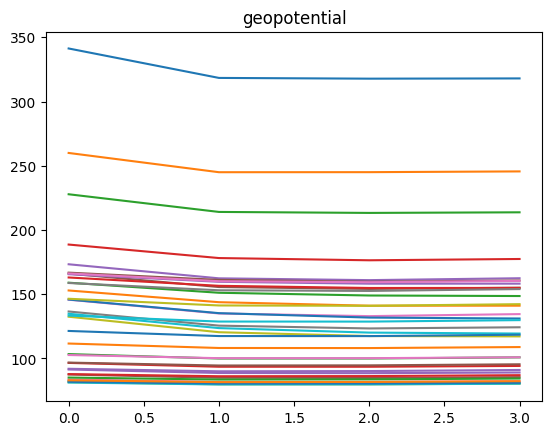

torch.Size([4, 37])


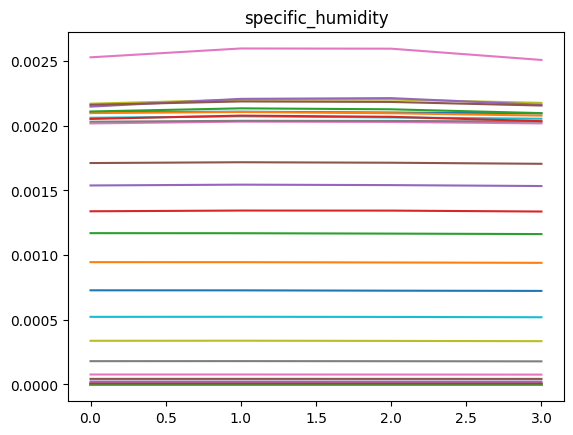

torch.Size([4, 37])


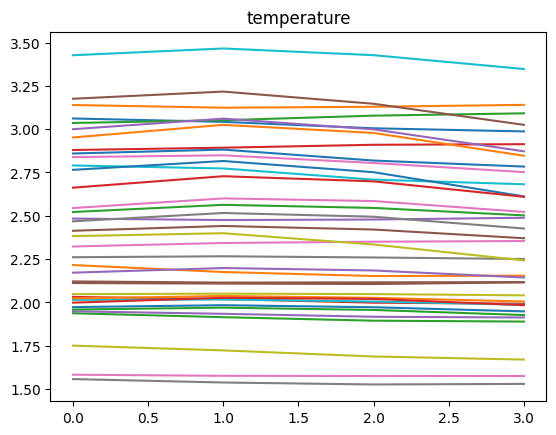

torch.Size([4, 37])


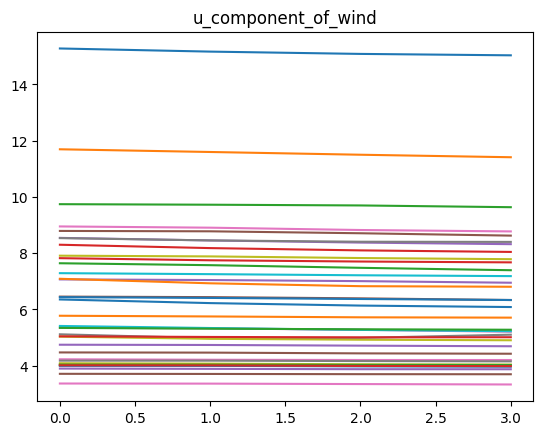

torch.Size([4, 37])


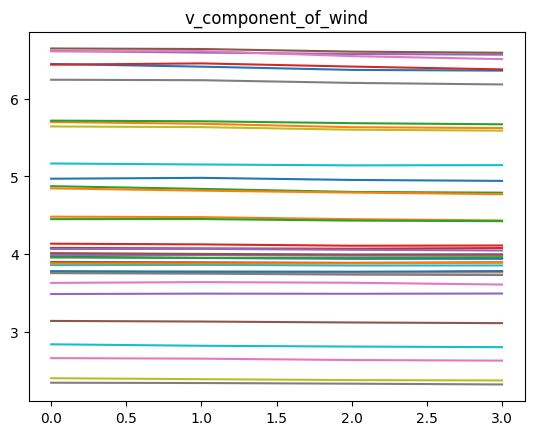

torch.Size([4, 37])


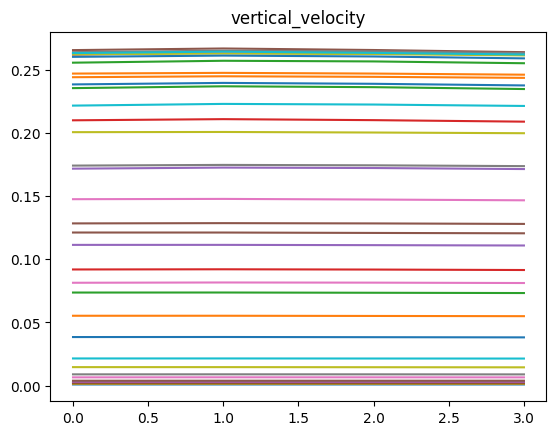

In [16]:
for var in config.training.air_variable:
        idx = WeatherDataset.AIR_VARIABLE.index(var) + 1
        air_list = [ ((idx-1)*37) + i for i in range(37)]
        visualize(torch.sqrt(loss_set[air_list]), var)